In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import (Dense, Conv2D, MaxPool2D, Dropout, 
                          Flatten, GlobalAveragePooling2D, Rescaling)

from sklearn.metrics import confusion_matrix, classification_report

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
sns.set_theme(style='darkgrid')

In [3]:
np.random.seed(42)

Download data from https://www.kaggle.com/puneet6060/intel-image-classification and save to data/

In [4]:
# path to files
train_path = 'data/seg_train/'
test_path = 'data/seg_test/'

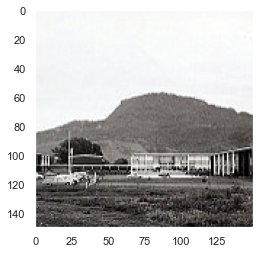

In [7]:
plt.grid(False)
plt.imshow(plt.imread(train_path + 'buildings/0.jpg'));

Here is a building from the buildings Collection

## Modeling

In [8]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

### Train and Test Data

Use image dataset from directory to use the folder structure to infer class names for all images

In [10]:
#Inferring labels goes in alphanumeric order, so will match our class names
train_data = image_dataset_from_directory(directory=train_path,
                                         labels='inferred',
                                         label_mode='categorical',
                                         class_names=class_names,
                                         color_mode='rgb',
                                         batch_size=32,
                                         image_size=(150, 150))

test_data = image_dataset_from_directory(directory=test_path,
                                         labels='inferred',
                                         label_mode='categorical',
                                         class_names=class_names,
                                         color_mode='rgb',
                                         batch_size=32,
                                         image_size=(150, 150))

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


### Basic Network

We'll fit a basic convolutional neural network to start with.

In [11]:
# instantiate the model
basic_model = Sequential()

#Rescale our data so color values are between 0 and 1
basic_model.add(Rescaling(1./255))

# this is the fancy stuff!
# 16 different 3-by-3 filters that pick up on patterns in the images
basic_model.add(Conv2D(filters=16,  # number of filters
                     kernel_size=(3, 3), # height/width of filter
                     activation='relu', # activation function
                     ))
# reduce the dimensionality inside the CNN
basic_model.add(MaxPool2D(pool_size=(2, 2))) # dimensions of region of pooling

# before this information inside the NN is 3-d -- to connec to a Dense
# layer, we need to squash it
basic_model.add(Flatten())

# let it learn a little more...
basic_model.add(Dense(100, activation='relu'))

# output layer
basic_model.add(Dense(6, activation='softmax'))

In [12]:
# compile
basic_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [13]:
# fit
basic_history = basic_model.fit(train_data,
                                validation_data=test_data,
                                epochs=5,
                                verbose=1)

Epoch 1/5
439/439 [==============================] - 146s 323ms/step - loss: 1.2707 - accuracy: 0.5973 - val_loss: 0.8274 - val_accuracy: 0.7170
Epoch 2/5
439/439 [==============================] - 102s 233ms/step - loss: 0.6903 - accuracy: 0.7608 - val_loss: 0.7686 - val_accuracy: 0.7387
Epoch 3/5
439/439 [==============================] - 100s 227ms/step - loss: 0.5008 - accuracy: 0.8314 - val_loss: 0.7627 - val_accuracy: 0.7243
Epoch 4/5
439/439 [==============================] - 98s 222ms/step - loss: 0.3283 - accuracy: 0.8982 - val_loss: 0.7876 - val_accuracy: 0.7403
Epoch 5/5
439/439 [==============================] - 98s 222ms/step - loss: 0.2134 - accuracy: 0.9374 - val_loss: 0.8453 - val_accuracy: 0.7343


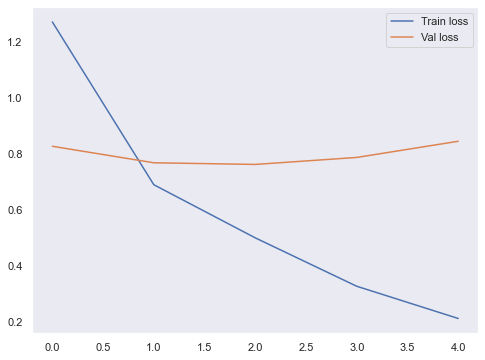

In [22]:
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.plot(basic_history.history['loss'], label='Train loss')
plt.plot(basic_history.history['val_loss'], label='Val loss')
plt.legend()
plt.show();

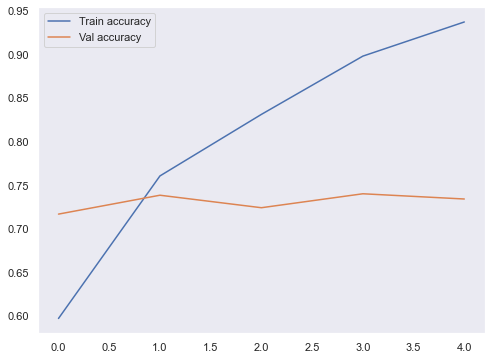

In [23]:
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.plot(basic_history.history['accuracy'], label='Train accuracy')
plt.plot(basic_history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.show();

Our custom built model is ok - it performs at just under 75% accuracy. However, we can do a lot better using transfer learning.

If we were going to put this model into production, we'd want to stop training it after 1 or 2 epochs, when the validation loss begins to move upward instead of declining, indicating the model is becoming overfit.

### Prebuilt Networks

Today we'll use `EfficientNet`. You can read more about the keras implementation of `EfficientNet` [here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#:~:text=Keras%20implementation%20of%20EfficientNet).

#### Import EfficientNet and freeze

In [24]:
#top = false so we don't get the output layer of effnet
effnet = EfficientNetV2L(include_top=False, weights='imagenet')

473176280/473176280 [==============================] - 12s 0us/step


In [26]:
#Set the model not to be trainable so we don't shift the weights of effnet
effnet.trainable = False


#### Add EfficientNet to a Sequential model

Between `EfficientNet` and our first Dense layer, we will need to use `GlobalAveragePooling2D()`. (This appears to be related to a bug inside of keras; you can read more [here](https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape).)

In [27]:
eff_model = Sequential()
eff_model.add(effnet)
#Add the pooling layer
eff_model.add(GlobalAveragePooling2D())
#Add our output layer
eff_model.add(Dense(6, activation='softmax'))

In [28]:
eff_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 117,754,534
Trainable params: 7,686
Non-trainable params: 117,746,848
_________________________________________________________________


#### Compile and evaluate

In [29]:
eff_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [30]:
eff_history = eff_model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
439/439 [==============================] - 3129s 7s/step - loss: 1.0472 - accuracy: 0.6964 - val_loss: 0.6587 - val_accuracy: 0.8190
Epoch 2/10
439/439 [==============================] - 3035s 7s/step - loss: 0.5740 - accuracy: 0.8402 - val_loss: 0.4767 - val_accuracy: 0.8537
Epoch 3/10
439/439 [==============================] - 2948s 7s/step - loss: 0.4547 - accuracy: 0.8618 - val_loss: 0.4051 - val_accuracy: 0.8700
Epoch 4/10
439/439 [==============================] - 2924s 7s/step - loss: 0.4006 - accuracy: 0.8742 - val_loss: 0.3660 - val_accuracy: 0.8793
Epoch 5/10
439/439 [==============================] - 2926s 7s/step - loss: 0.3690 - accuracy: 0.8793 - val_loss: 0.3404 - val_accuracy: 0.8887
Epoch 6/10
439/439 [==============================] - 2904s 7s/step - loss: 0.3439 - accuracy: 0.8858 - val_loss: 0.3238 - val_accuracy: 0.8933
Epoch 7/10
439/439 [==============================] - 2775s 6s/step - loss: 0.3294 - accuracy: 0.8915 - val_loss: 0.3103 - val_accuracy:

Note: During the hackathon, we used one of my teammate's computers to do the training. His GPU enabled us to fit the data much more quickly, in 45 minutes instead of hours.

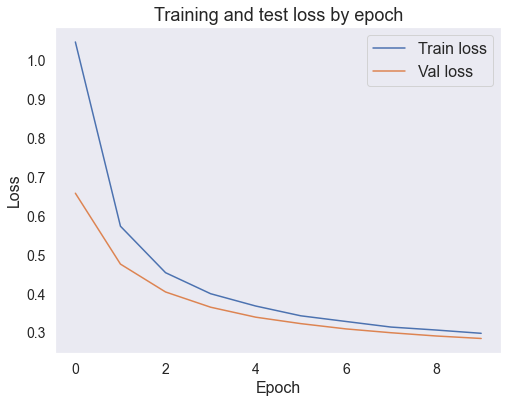

In [43]:
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.title('Training and test loss by epoch', size=18)
plt.plot(eff_history.history['loss'], label='Train loss')
plt.plot(eff_history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show();

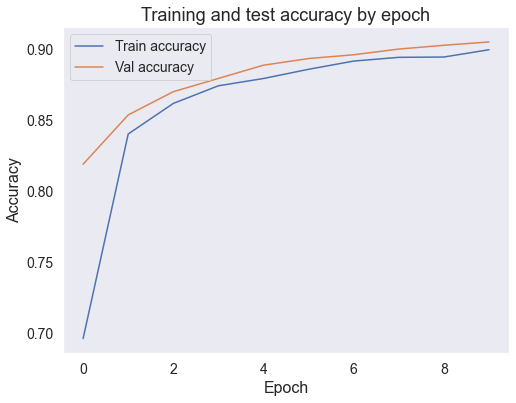

In [44]:
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.title('Training and test accuracy by epoch', size=18)
plt.plot(eff_history.history['accuracy'], label='Train accuracy')
plt.plot(eff_history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show();

Appears that it could train for longer without overfitting to our training data, but leaving it here due to time constraints.

# Confusion matrix

Let's look at how our model performed on the different combinations of images. From looking at some of the images, it should be hardest to tell the difference between mountains and glaciers and streets and buildings - in many cases, those images contain both things, despite being sorted into different classes.

First, we need to use image_dataset_from_directory to bring in our test data again without shuffling to make predictions against it.

In [65]:
pred_data = image_dataset_from_directory(directory=test_path,
                                         labels='inferred',
                                         label_mode='categorical',
                                         class_names=class_names,
                                         color_mode='rgb',
                                         batch_size=32,
                                         image_size=(150, 150),
                                         shuffle=False)

Found 3000 files belonging to 6 classes.


In [66]:
#Get our true labels into correct shape
y = np.concatenate([y for x, y in pred_data], axis=0)
y = np.where(y==1)[1]

#Get predicted labels
y_pred_array = eff_model.predict(pred_data)
y_pred = np.argmax(y_pred_array, axis=1)

#Create confusion matrix and classification report
print('Confusion Matrix')
matrix = confusion_matrix(y, y_pred, normalize='true')
print(matrix)
print('Classification Report')
print(classification_report(y, y_pred, target_names=class_names))

94/94 [==============================] - 497s 5s/step
Confusion Matrix
[[0.8993135  0.00228833 0.         0.         0.00915332 0.08924485]
 [0.0021097  0.98734177 0.0021097  0.00632911 0.0021097  0.        ]
 [0.00361664 0.00180832 0.80470163 0.12477396 0.05786618 0.00723327]
 [0.         0.00190476 0.12571429 0.8552381  0.0152381  0.00190476]
 [0.00588235 0.00392157 0.01372549 0.00588235 0.97058824 0.        ]
 [0.05988024 0.         0.         0.00598802 0.00598802 0.92814371]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.92      0.90      0.91       437
      forest       0.99      0.99      0.99       474
     glacier       0.86      0.80      0.83       553
    mountain       0.85      0.86      0.85       525
         sea       0.91      0.97      0.94       510
      street       0.91      0.93      0.92       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weig

## Create heatmap 

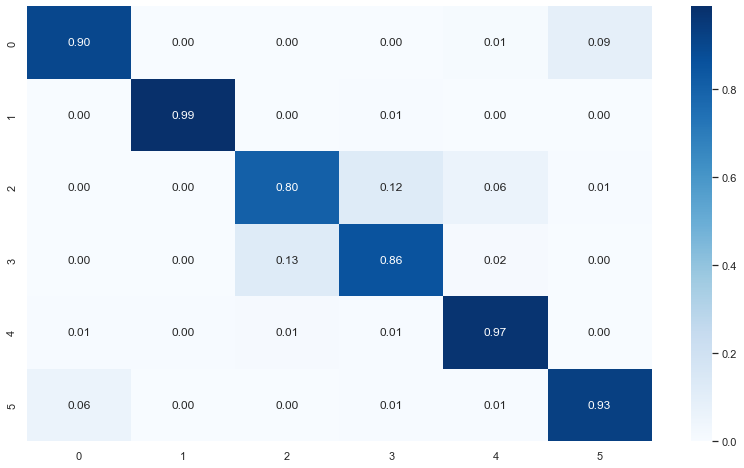

In [67]:
sns.set(rc = {'figure.figsize':(14, 8)})
sns.heatmap(matrix, annot=True,fmt='.2f', cmap="Blues");

### Can you tell the difference between these pictures?

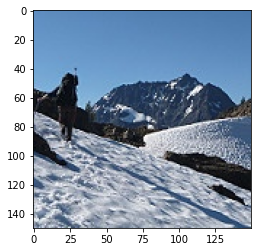

In [24]:
mountain = random.choice(os.listdir("data/seg_train/mountain"))
plt.imshow(plt.imread(f'data/seg_train/mountain/{mountain}'));
plt.show()

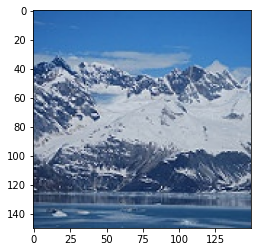

In [13]:
glacier = random.choice(os.listdir("data/seg_train/glacier"))
plt.imshow(plt.imread(f'data/seg_train/glacier/{glacier}'));
plt.show()

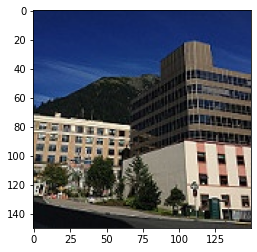

In [31]:
buildings = random.choice(os.listdir("data/seg_train/buildings"))
plt.imshow(plt.imread(f'data/seg_train/buildings/{buildings}'));
plt.show()

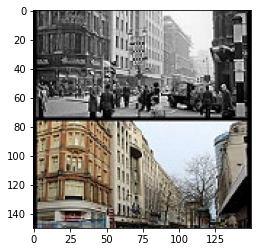

In [29]:
street = random.choice(os.listdir("data/seg_train/street"))
plt.imshow(plt.imread(f'data/seg_train/street/{street}'));
plt.show()